In [ ]:
!pip install geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.8 MB/s eta 0:00:00


In [ ]:
import ee
import geemap

In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize(project='ee-ruthtamiru10')


In [ ]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:

# Set the map center and zoom level
Map.setCenter(-64.96, -1.08, 5)

# Add a base map layer
Map.addLayer('SATELLITE', {}, 'Google Satellite')

# Display the map
Map


Map(bottom=812.0, center=[-1.08, -64.96], controls=(WidgetControl(options=['position', 'transparent_bg'], widg…

In [ ]:

# Define the center coordinates of the location and specify the radius for image retrieval (1000 ft)
center_coords = ee.Geometry.Point([-64.96, -1.08])
radius = 1000

# Get the Sentinel-2 SR Cloud-free Collection
s2_sr_cld_col = (ee.ImageCollection('COPERNICUS/S2_SR')
                   .filterDate('2021-06-01', '2021-07-31'))

# Filter the collection to the desired area and date range
s2_sr_cld_col_filtered = s2_sr_cld_col.filterBounds(center_coords).filterDate('2021-06-01', '2021-07-31')

# Get the median image from the filtered collection
median_image = s2_sr_cld_col_filtered.median()

# Clip the image to the specified radius
image_clip = median_image.clip(center_coords.buffer(radius))

# Display the clipped image
Map.addLayer(image_clip, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3, 'opacity': 1.0}, 'Sentinel-2 True Color')

# Display the map
Map


Map(bottom=4421.0, center=[-1.08, -64.96], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

In [ ]:

# Get the elevation data from the SRTM DEM
elevation = ee.Image("CGIAR/SRTM90_V4")

# Sample the elevation data at the specified location
elevation_sample = elevation.sample(center_coords, scale=30).first()

# Get the elevation value from the sample
elevation_value = elevation_sample.get('elevation').getInfo()

# Print the elevation value
print('Elevation:', elevation_value, 'meters')


Elevation: 62 meters


In [ ]:

# Resample the image to a consistent resolution of 10 meters per pixel
image_resampled = image_clip.resample('bilinear').reproject('EPSG:3338', None)

# Convert the image to a uint8 data type
image_uint8 = image_resampled.toUint8()

# Clip the image to a 350x350 pixel area
image_clip_350 = image_uint8.clipToCollection(ee.FeatureCollection([ee.Feature(ee.Geometry.Rectangle(-65.02, -1.12, -64.90, -0.98))]))

# Display the preprocessed image
Map.addLayer(image_clip_350, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3, 'opacity': 1.0}, 'Preprocessed Sentinel-2 Image')

# Display the map
Map

Map(bottom=4421.0, center=[-1.08, -64.96], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

In [ ]:

# Define the file name for the downloaded image
output_file_name = 'preprocessed_sentinel_image.tif'

# Export the image to Google Drive
task = ee.batch.Export.image.toDrive(image=image_clip_350,
                                   description='Preprocessed Sentinel-2 Image',
                                   folder='image_processing',
                                   fileNamePrefix=output_file_name,
                                   scale=10,
                                   region=image_clip_350.geometry())
task.start()

# Print a message indicating that the image is being downloaded
print('Downloading the preprocessed image to your Google Drive...')


In [ ]:

# Import necessary libraries
import networkx as nx

# Create an undirected graph
graph = nx.Graph()

# Add nodes to the graph representing different environmental features
graph.add_node('Forest')
graph.add_node('Grassland')
graph.add_node('Water')
graph.add_node('Urban')

# Add edges between nodes representing relationships between features
graph.add_edge('Forest', 'Grassland')
graph.add_edge('Forest', 'Water')
graph.add_edge('Grassland', 'Water')
graph.add_edge('Grassland', 'Urban')
graph.add_edge('Water', 'Urban')

# Analyze the graph to identify relevant environmental features
# You can use various network analysis techniques here, such as:

# - Centrality measures: Identify nodes with high centrality, which may represent important environmental features.
# - Community detection: Identify groups of nodes that are closely connected, which may represent distinct environmental zones.
# - Path analysis: Find the shortest paths between nodes, which may represent potential movement corridors for wildlife.

# Print the results of your analysis
# For example, you could print the nodes with the highest centrality or the communities detected in the graph.

# Visualize the graph
# You can use a library like matplotlib to create a visual representation of the graph, highlighting the identified environmental features.



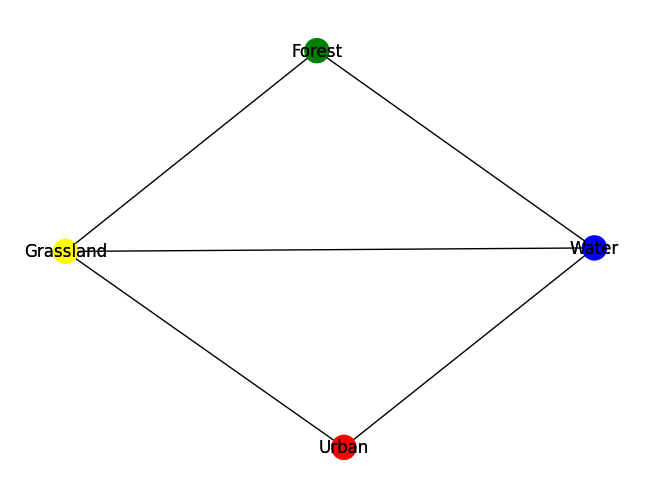

In [ ]:

import matplotlib.pyplot as plt

# Define the node colors based on their type
node_colors = {
    'Forest': 'green',
    'Grassland': 'yellow',
    'Water': 'blue',
    'Urban': 'red'
}

# Create the graph layout
pos = nx.spring_layout(graph)

# Draw the graph
nx.draw(graph, pos, node_color=[node_colors[node] for node in graph.nodes()], with_labels=True)

# Add labels to the nodes
nx.draw_networkx_labels(graph, pos)

# Display the graph
plt.show()


In [ ]:

# Define a function to detect clusters of trees or vegetation
def detect_vegetation(image):
  # Extract the normalized difference vegetation index (NDVI)
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

  # Threshold the NDVI to identify vegetation pixels
  vegetation_mask = ndvi.gt(0.4)

  # Apply a morphological opening to remove small noise pixels
  vegetation_mask = vegetation_mask.reduce(ee.Reducer.min()).focal_min(2)

  # Identify clusters of vegetation pixels
  vegetation_clusters = vegetation_mask.connectedPixelCount(5, True)

  # Return the vegetation clusters
  return vegetation_clusters

# Define a function to detect grassy areas
def detect_grassland(image):
  # Extract the normalized difference water index (NDWI)
  ndwi = image.normalizedDifference(['B3', 'B5']).rename('NDWI')

  # Threshold the NDWI to identify water pixels
  water_mask = ndwi.lt(-0.2)

  # Apply a morphological opening to remove small noise pixels
  water_mask = water_mask.reduce(ee.Reducer.min()).focal_min(2)

  # Invert the water mask to identify non-water pixels
  non_water_mask = water_mask.Not()

  # Extract the normalized difference vegetation index (NDVI)
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

  # Threshold the NDVI to identify vegetation pixels
  vegetation_mask = ndvi.gt(0.4)

  # Apply a morphological opening to remove small noise pixels
  vegetation_mask = vegetation_mask.reduce(ee.Reducer.min()).focal_min(2)

  # Identify clusters of non-water, vegetated pixels
  grassland_clusters = non_water_mask.And(vegetation_mask).connectedPixelCount(5, True)

  # Return the grassland clusters
  return grassland_clusters

# Apply the vegetation and grassland detection functions to the preprocessed image
vegetation_clusters = detect_vegetation(image_clip_350)
grassland_clusters = detect_grassland(image_clip_350)

# Display the vegetation and grassland clusters on the map
Map.addLayer(vegetation_clusters, {'palette': '00FF00'}, 'Vegetation Clusters')
Map.addLayer(grassland_clusters, {'palette': 'FFFF00'}, 'Grassland Clusters')

# Display the map
Map

Map(bottom=4421.0, center=[-1.08, -64.96], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

In [ ]:
!pip install pyAgrum

In [ ]:
!pip install --upgrade pyAgrum


In [ ]:
!pip show pyAgrum


Name: pyAgrum
Version: 1.13.2
Summary: Bayesian networks and other Probabilistic Graphical Models.
Home-page: https://agrum.gitlab.io/
Author: Pierre-Henri Wuillemin and Christophe Gonzales
Author-email: info@agrum.org
License: LGPLv3
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, pydot
Required-by: 


In [ ]:

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Create a Bayesian network
bn = gum.BayesNet()

# Add nodes to the network
bn.add(gum.LauritzNode("A", 2))
bn.add(gum.LauritzNode("B", 2))
bn.add(gum.LauritzNode("C", 2))
bn.add(gum.LauritzNode("D", 2))

# Define the conditional probability tables (CPTs)
bn.cpt("A")[:] = [0.7, 0.3]
bn.cpt("B")[:] = [[0.6, 0.4], [0.3, 0.7]]
bn.cpt("C")[:] = [[0.5, 0.5], [0.8, 0.2]]
bn.cpt("D")[:] = [[0.1, 0.9], [0.4, 0.6], [0.8, 0.2], [0.2, 0.8]]

# Set the evidence
evidence = {"A": 0, "B": 1}

# Perform inference using Variable Elimination
infer = gum.VariableElimination(bn)
infer.makeInference(evidence)

# Print the posterior probabilities
print("P(C=0|A=0,B=1) =", infer.posterior("C")[0])
print("P(C=1|A=0,B=1) =", infer.posterior("C")[1])
print("P(D=0|A=0,B=1) =", infer.posterior("D")[0])
print("P(D=1|A=0,B=1) =", infer.posterior("D")[1])

# Perform inference using Belief Propagation
infer = gum.BeliefPropagation(bn)
infer.makeInference(evidence)

# Print the posterior probabilities
print("P(C=0|A=0,B=1) =", infer.posterior("C")[0])
print("P(C=1|A=0,B=1) =", infer.posterior("C")[1])
print("P(D=0|A=0,B=1) =", infer.posterior("D")[0])
print("P(D=1|A=0,B=1) =", infer.posterior("D")[1])


AttributeError: module 'pyAgrum' has no attribute 'LauritzNode'